In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [3]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [4]:
BPs2plot = [1,4,7,10,13]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [5]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [6]:
ttgamma_cross = 0.144 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

In [7]:
Wgamma_fidcross  = 584.6234734948906
Wjets_fidcross   = 600.5788869631236
ttgamma_fidcross = 28.773979008
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1213.9763394660142

In [8]:
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)

In [9]:
Wgamma_expected  = 58462.347349489064
Wjets_expected   = 60057.888696312366
ttgamma_expected = 2877.3979008
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [10]:
sample = 200_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

96315
98944
4740


In [11]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [12]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [13]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)

156139
160401
7685


In [14]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])

In [15]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1
bkg_flag_pool[Wgamma_pool_sample:(Wgamma_pool_sample + Wjets_pool_sample)] = 2
bkg_flag_pool[(Wgamma_pool_sample + Wjets_pool_sample):] = 3

In [16]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(259345, 4)
(2052938, 4)
(3579946, 4)


In [17]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_5.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_5.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_5.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_5.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_5.dat', delimiter=' ') )

In [18]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (199999, 5)
BP1 (524041, 5)
BP2 (492157, 5)
BP3 (414951, 5)
BP4 (603424, 5)
BP5 (533112, 5)
BP6 (406048, 5)
BP7 (631234, 5)
BP8 (560590, 5)
BP9 (451741, 5)
BP10 (652300, 5)
BP11 (583750, 5)
BP12 (488317, 5)
BP13 (670737, 5)
BP14 (602479, 5)
BP15 (516051, 5)


In [19]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([524041, 492157, 414951, 603424, 533112, 406048, 631234, 560590, 451741, 652300, 583750, 488317, 670737, 602479, 516051])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [20]:
# other variables, individual channels:

ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [21]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

In [22]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [23]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(199999, 4)
(524041, 4)


# Plots

In [ ]:
# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


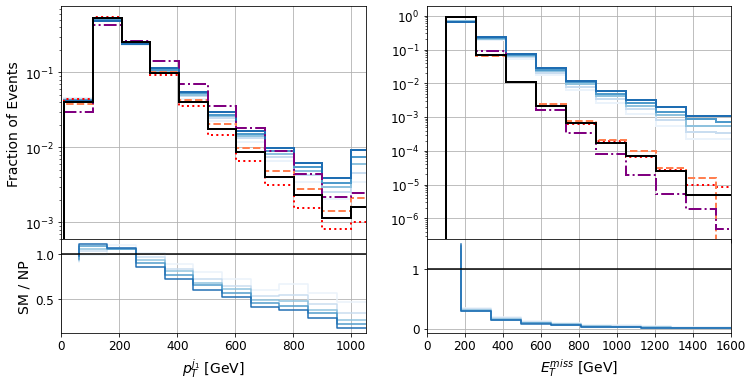

In [26]:
fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Pt jet -----------------------------------------------------------------------------------------------------------------------
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
h_sm = ax[0,0].hist(jet_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    h_np = ax[0,0].hist(jet_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
ax[0,0].hist(jet_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
ax[0,0].hist(jet_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
ax[0,0].hist(jet_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1050)
ax[1,0].set_xlim(0,1050)
ax[0,0].set_xticklabels([])
ax[1,0].axhline(y = 1, color = 'black')
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)

# Pt MET -----------------------------------------------------------------------------------------------------------------------
nbins = np.asarray([ 100.01,  257.88,  415.75,  573.62,  731.49,  889.36, 1047.23, 1205.1 , 1362.97, 1520.84, 16780.71])

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
h_sm = ax[0,1].hist(MET_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    h_np = ax[0,1].hist(MET_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
ax[0,1].hist(MET_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
ax[0,1].hist(MET_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
ax[0,1].hist(MET_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,1600)
ax[1,1].set_xlim(0,1600)
ax[0,1].set_xticklabels([])
ax[1,1].axhline(y = 1, color = 'black')

plt.savefig('../graph/PT_jet_PT_MET_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_2921285/2046523717.py:91: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,2].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))


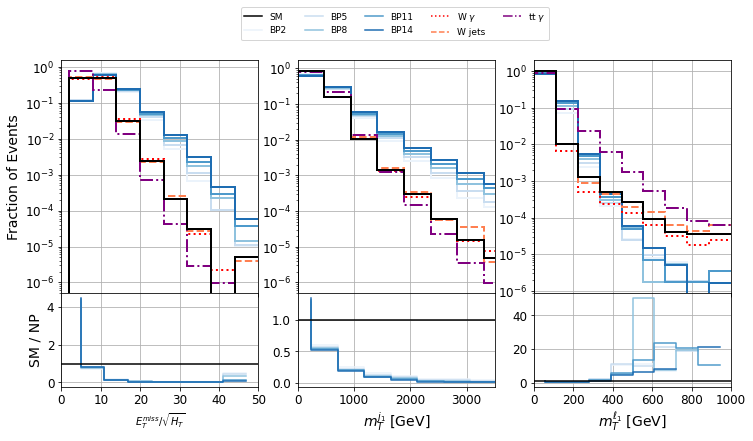

In [27]:
fig,ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Met info -----------------------------------------------------------------------------------------------------------------------
nbins = np.asarray([ 1.88,  7.89, 13.911, 19.92, 25.93, 31.94, 37.961, 43.97, 100])

weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
h_sm = ax[0,0].hist(MET_sig_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    h_np = ax[0,0].hist(MET_sig_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
ax[0,0].hist(MET_sig_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
ax[0,0].hist(MET_sig_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
ax[0,0].hist(MET_sig_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}}$")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,50)
ax[1,0].set_xlim(0,50)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])

    
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].legend(loc='upper right',fontsize=9,bbox_to_anchor=(2.5, 1.25), ncol = 5)

# Mt jet info -----------------------------------------------------------------------------------------------------------------------

nbins = np.asarray([ 0., 472.23, 944.46, 1416.69, 1888.92, 2361.15, 2833.38, 3305.61, 13777.84])

weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
h_sm = ax[0,1].hist(mT_jet_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    h_np = ax[0,1].hist(mT_jet_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
ax[0,1].hist(mT_jet_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
ax[0,1].hist(mT_jet_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
ax[0,1].hist(mT_jet_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,3500)
ax[1,1].set_xlim(0,3500)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------

nbins = np.asarray([ 0., 111.1, 222.22, 333.33, 444.44, 555.55, 666.6, 777.7, 888.88, 10000.])

weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
h_sm = ax[0,2].hist(mT_lepton_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,2].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    h_np = ax[0,2].hist(mT_lepton_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,2].plot([],[], label=name[i], color=cmap(i))
    ax[1,2].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
ax[0,2].hist(mT_lepton_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,2].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
ax[0,2].hist(mT_lepton_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,2].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
ax[0,2].hist(mT_lepton_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,2].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,2].grid()
ax[1,2].grid()
ax[1,2].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[1,2].set_ylabel("")
ax[0,2].set_yscale('log')
ax[0,2].set_xlim(0,1000)
ax[1,2].set_xlim(0,1000)
ax[1,2].axhline(y = 1, color = 'black')
ax[0,2].set_xticklabels([])

plt.savefig('../graph/METs_mjet_mlepton_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_2921285/3578523426.py:15: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))


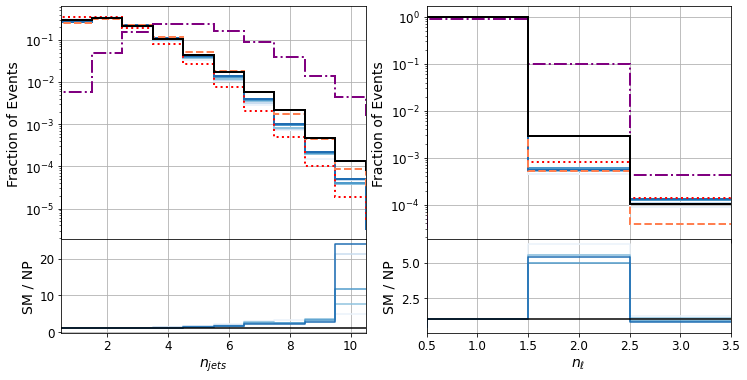

In [28]:
fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))


# Num jets
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

weights = np.ones_like(hadinfo_SM[:,2])/len(hadinfo_SM[:,2])
h_sm = ax[0,0].hist(hadinfo_SM[:,2], weights=weights, bins = nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,2])/len(hadinfo_NP[i][:,2])
    h_np = ax[0,0].hist(hadinfo_NP[i][:,2], weights=weights, bins = nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,2])/len(hadinfo_Wgamma[:,2])
ax[0,0].hist(hadinfo_Wgamma[:,2], weights=weights, bins = nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,2])/len(hadinfo_Wjets[:,2])
ax[0,0].hist(hadinfo_Wjets[:,2], weights=weights, bins = nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,2])/len(hadinfo_ttgamma[:,2])
ax[0,0].hist(hadinfo_ttgamma[:,2], weights=weights, bins = nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0.5,10.5)
ax[1,0].set_xlim(0.5,10.5)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)

# Num leptons
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

weights = np.ones_like(lepton_SM[:,3])/len(lepton_SM[:,3])
h_sm = ax[0,1].hist(lepton_SM[:,3], weights=weights, bins = nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,3])/len(lepton_NP[i][:,3])
    h_np = ax[0,1].hist(lepton_NP[i][:,3], weights=weights, bins = nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][1:] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,3])/len(lepton_Wgamma[:,3])
ax[0,1].hist(lepton_Wgamma[:,3], weights=weights, bins = nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,3])/len(lepton_Wjets[:,3])
ax[0,1].hist(lepton_Wjets[:,3], weights=weights, bins = nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,3])/len(lepton_ttgamma[:,3])
ax[0,1].hist(lepton_ttgamma[:,3], weights=weights, bins = nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0.5,3.5)
ax[1,1].set_xlim(0.5,3.5)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])

ax[0,1].set_ylabel("Fraction of Events",fontsize=14)
ax[1,1].set_ylabel("SM / NP", fontsize=14)


plt.savefig('../graph/njets_nleptons_dist.pdf', bbox_inches='tight')

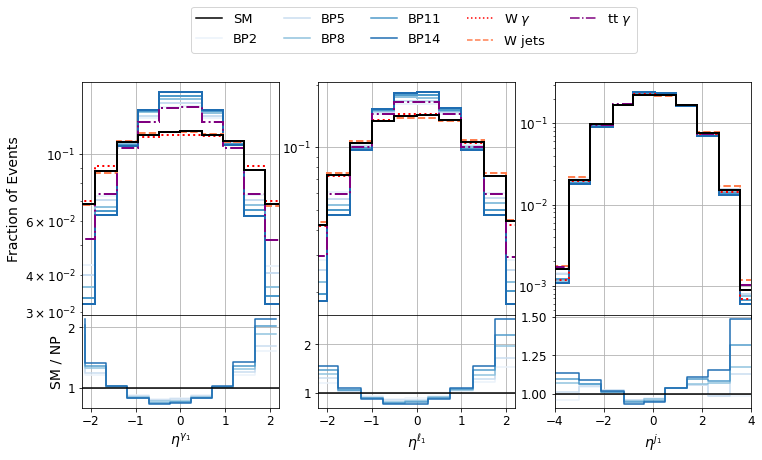

In [29]:
fig,ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
nbins = 10


weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
h_sm = ax[0,0].hist(photon_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    h_np = ax[0,0].hist(photon_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
ax[0,0].hist(photon_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
ax[0,0].hist(photon_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
ax[0,0].hist(photon_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(-2.2,2.2)
ax[1,0].set_xlim(-2.2,2.2)
ax[0,0].set_xticklabels([])
ax[1,0].axhline(y = 1, color = 'black')
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[0,0].legend(loc='upper right',fontsize=13,bbox_to_anchor=(2.85, 1.35), ncol = 5)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
nbins = 10


weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
h_sm = ax[0,1].hist(lepton_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    h_np = ax[0,1].hist(lepton_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
ax[0,1].hist(lepton_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
ax[0,1].hist(lepton_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
ax[0,1].hist(lepton_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(-2.2,2.2)
ax[1,1].set_xlim(-2.2,2.2)
ax[0,1].set_xticklabels([])
ax[1,1].axhline(y = 1, color = 'black')

# eta jet -----------------------------------------------------------------------------------------------------------------------
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])


weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
h_sm = ax[0,2].hist(jet_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    h_np = ax[0,2].hist(jet_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,2].plot([],[], label=name[i], color=cmap(i))
    ax[1,2].step( (h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
ax[0,2].hist(jet_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,2].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
ax[0,2].hist(jet_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,2].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
ax[0,2].hist(jet_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,2].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,2].grid()
ax[1,2].grid()
ax[1,2].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[1,2].set_ylabel("")
ax[0,2].set_yscale('log')
ax[0,2].set_xlim(-4.,4.)
ax[1,2].set_xlim(-4.,4.)
ax[0,2].set_xticklabels([])
ax[1,2].axhline(y = 1, color = 'black')

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_2921285/987628894.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))


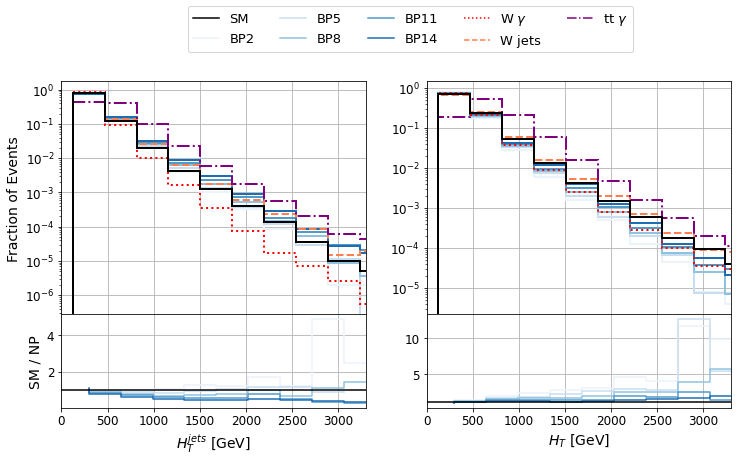

In [30]:
nbins = np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Ht info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]

weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
h_sm = ax[0,0].hist(hadinfo_SM[:,1], weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    h_np = ax[0,0].hist(hadinfo_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
ax[0,0].hist(hadinfo_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
ax[0,0].hist(hadinfo_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
ax[0,0].hist(hadinfo_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,3300)
ax[1,0].set_xlim(0,3300)
ax[1,0].axhline(y = 1, color = 'black') 
ax[0,0].set_xticklabels([])

weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
h_sm = ax[0,1].hist(hadinfo_SM[:,0], weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    h_np = ax[0,1].hist(hadinfo_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
ax[0,1].hist(hadinfo_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
ax[0,1].hist(hadinfo_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
ax[0,1].hist(hadinfo_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,3300)
ax[1,1].set_xlim(0,3300)
ax[1,1].axhline(y = 1, color = 'black')     
ax[0,1].set_xticklabels([])

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,1].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.70, 1.35), ncol = 5)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

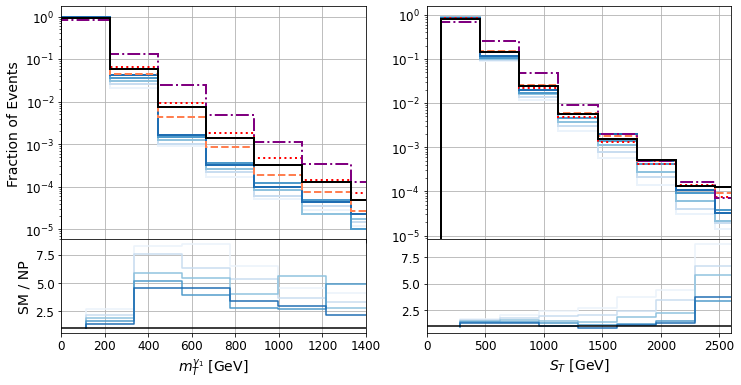

In [31]:
nbins = np.asarray([0, 221.6, 443.3, 664.9, 886.6, 1108.30239502, 1329.96287402, 1773.28383203])

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Mt photon

weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
h_sm = ax[0,0].hist(mT_photon_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    h_np = ax[0,0].hist(mT_photon_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
ax[0,0].hist(mT_photon_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
ax[0,0].hist(mT_photon_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
ax[0,0].hist(mT_photon_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1400)
ax[1,0].set_xlim(0,1400)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])


# ST info

nbins = np.asarray([121.1, 455.7, 790.4, 1125.0, 1459.6, 1794.3, 2128.9, 2463.625, 3467.56])
weights = np.ones_like(ST_SM)/len(ST_SM)
h_sm = ax[0,1].hist(ST_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(ST_NP[i])/len(ST_NP[i])
    h_np = ax[0,1].hist(ST_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(ST_Wgamma)/len(ST_Wgamma)
ax[0,1].hist(ST_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(ST_Wjets)/len(ST_Wjets)
ax[0,1].hist(ST_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(ST_ttgamma)/len(ST_ttgamma)
ax[0,1].hist(ST_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,2600)
ax[1,1].set_xlim(0,2600)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)

plt.savefig('../graph/mt_photon_ST_dist.pdf', bbox_inches='tight')


/tmp/ipykernel_3400634/2432099688.py:18: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))


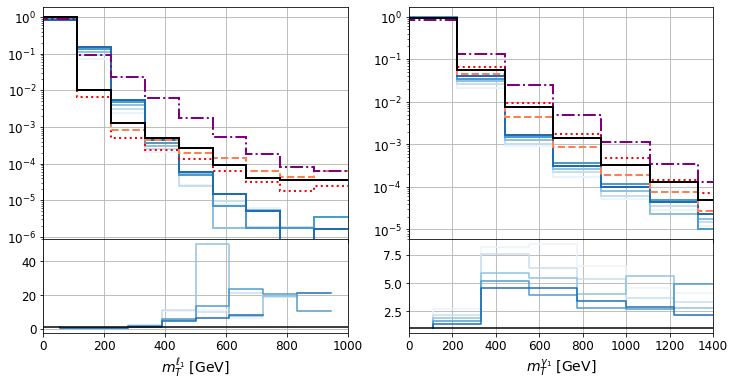

In [32]:
nbins = np.asarray([0, 221.6, 443.3, 664.9, 886.6, 1108.30239502, 1329.96287402, 1773.28383203])

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------

nbins = np.asarray([ 0., 111.1, 222.22, 333.33, 444.44, 555.55, 666.6, 777.7, 888.88, 10000.])

weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
h_sm = ax[0,0].hist(mT_lepton_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    h_np = ax[0,0].hist(mT_lepton_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
ax[0,0].hist(mT_lepton_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
ax[0,0].hist(mT_lepton_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
ax[0,0].hist(mT_lepton_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1000)
ax[1,0].set_xlim(0,1000)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])

# Mt photon
nbins = np.asarray([0, 221.6, 443.3, 664.9, 886.6, 1108.30239502, 1329.96287402, 1773.28383203])

weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
h_sm = ax[0,1].hist(mT_photon_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    h_np = ax[0,1].hist(mT_photon_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
ax[0,1].hist(mT_photon_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
ax[0,1].hist(mT_photon_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
ax[0,1].hist(mT_photon_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,1400)
ax[1,1].set_xlim(0,1400)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])


plt.savefig('../graph/mt_lepton_mt_photon.pdf', bbox_inches='tight')

/tmp/ipykernel_3400634/2433456470.py:14: RuntimeWarning: invalid value encountered in true_divide
  ax[1].step(h_sm[1][:-1]+0.5, h_sm[0] / h_np[0], color=cmap(i), where = 'mid')


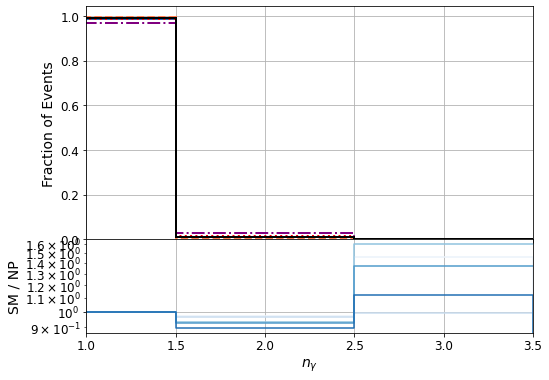

In [30]:
fig,ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (8,6))

# Num photons
bins = [0.5,1.5,2.5,3.5,4.5]
weights = np.ones_like(photon_SM[:,3])/len(photon_SM[:,3])
h_sm = ax[0].hist(photon_SM[:,3], weights=weights, lw=2, edgecolor='black', histtype='step', zorder=20, bins = bins)
ax[0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,3])/len(photon_NP[i][:,3])
    h_np = ax[0].hist(photon_NP[i][:,3], weights=weights, lw=2, edgecolor=cmap(i), histtype='step', zorder=2, bins = bins)
    ax[0].plot([],[], label=name[i], color=cmap(i))
    #print(h_sm[0] / h_np[0])
    ax[1].step(h_sm[1][:-1]+0.5, h_sm[0] / h_np[0], color=cmap(i), where = 'mid')

weights = np.ones_like(photon_Wgamma[:,3])/len(photon_Wgamma[:,3])
ax[0].hist(photon_Wgamma[:,3], weights=weights, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step', bins = bins)
ax[0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,3])/len(photon_Wjets[:,3])
ax[0].hist(photon_Wjets[:,3], weights=weights, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step', bins = bins)
ax[0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,3])/len(photon_ttgamma[:,3])
ax[0].hist(photon_ttgamma[:,3], weights=weights, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step', bins = bins)
ax[0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[0].set_ylabel("")
ax[1].set_yscale('log')
ax[0].set_xlim(1,3.5)
ax[1].set_xlim(1,3.5)
#ax[1].set_ylim(0.8,1.51)
#ax[1].axhline(y = 1, color = 'black')

ax[0].set_ylabel("Fraction of Events",fontsize=14)
ax[1].set_ylabel("SM / NP", fontsize=14)
ax[0].set_xticklabels([])

plt.savefig('../graph/nphoton_dist.pdf', bbox_inches='tight')

### Main

/tmp/ipykernel_2921285/1972267400.py:18: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_2921285/1972267400.py:61: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))


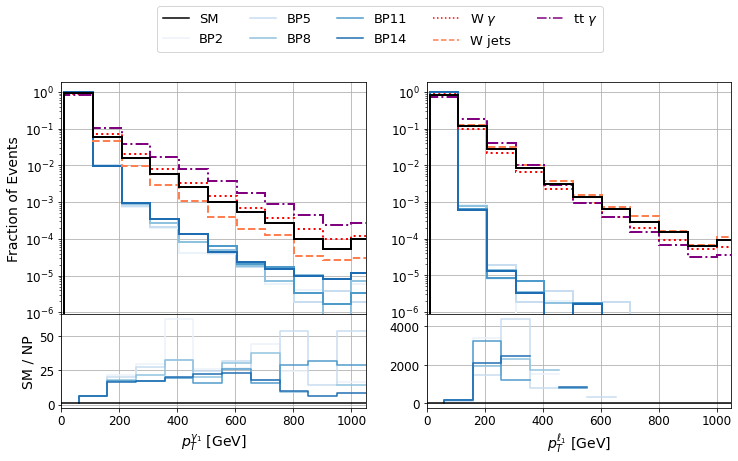

In [25]:
fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
nbins     = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
h_sm = ax[0,0].hist(photon_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    h_np = ax[0,0].hist(photon_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
ax[0,0].hist(photon_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
ax[0,0].hist(photon_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
ax[0,0].hist(photon_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1050)
ax[1,0].set_xlim(0,1050)
ax[0,0].set_xticklabels([])
ax[1,0].axhline(y = 1, color = 'black')
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[0,0].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.80, 1.35), ncol = 5)


# Pt lepton -----------------------------------------------------------------------------------------------------------------------
nbins  = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
h_sm = ax[0,1].hist(lepton_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    h_np = ax[0,1].hist(lepton_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
ax[0,1].hist(lepton_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
ax[0,1].hist(lepton_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
ax[0,1].hist(lepton_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,1050)
ax[1,1].set_xlim(0,1050)
ax[0,1].set_xticklabels([])
ax[1,1].axhline(y = 1, color = 'black')

plt.savefig('../graph/PT_photon_PT_lepton_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_3400634/2831662591.py:57: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))


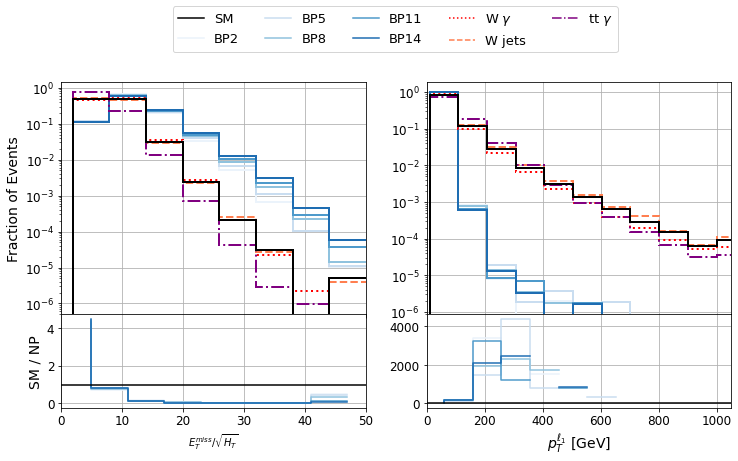

In [28]:
fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# MET sig -----------------------------------------------------------------------------------------------------------------------
nbins = np.asarray([ 1.88,  7.89, 13.911, 19.92, 25.93, 31.94, 37.961, 43.97, 100])

weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
h_sm = ax[0,0].hist(MET_sig_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    h_np = ax[0,0].hist(MET_sig_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
ax[0,0].hist(MET_sig_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
ax[0,0].hist(MET_sig_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
ax[0,0].hist(MET_sig_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}}$")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,50)
ax[1,0].set_xlim(0,50)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])

    
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.85, 1.35), ncol = 5)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
nbins  = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
h_sm = ax[0,1].hist(lepton_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    h_np = ax[0,1].hist(lepton_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
ax[0,1].hist(lepton_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
ax[0,1].hist(lepton_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
ax[0,1].hist(lepton_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,1050)
ax[1,1].set_xlim(0,1050)
ax[0,1].set_xticklabels([])
ax[1,1].axhline(y = 1, color = 'black')

plt.savefig('../graph/MET_sig_PT_lepton_dist.pdf', bbox_inches='tight')

### Apendix

/tmp/ipykernel_820742/362992195.py:18: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))


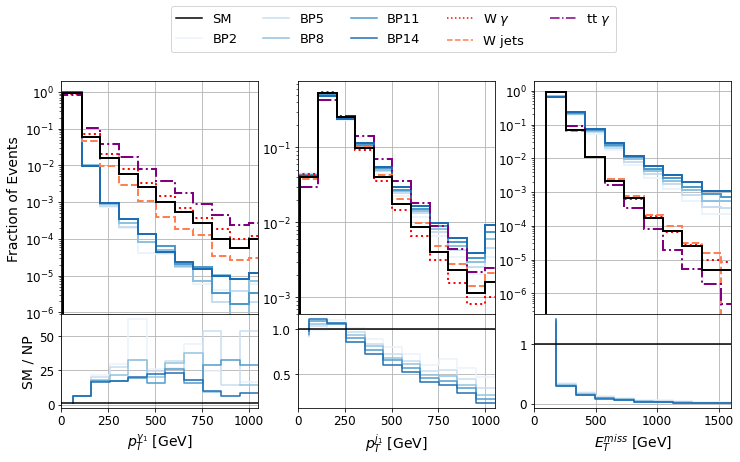

In [24]:
fig,ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
nbins     = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
h_sm = ax[0,0].hist(photon_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    h_np = ax[0,0].hist(photon_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
ax[0,0].hist(photon_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
ax[0,0].hist(photon_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
ax[0,0].hist(photon_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1050)
ax[1,0].set_xlim(0,1050)
ax[0,0].set_xticklabels([])
ax[1,0].axhline(y = 1, color = 'black')
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[0,0].legend(loc='upper right',fontsize=13,bbox_to_anchor=(2.85, 1.35), ncol = 5)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])


weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
h_sm = ax[0,ncol].hist(jet_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    h_np = ax[0,ncol].hist(jet_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,ncol].plot([],[], label=name[i], color=cmap(i))
    ax[1,ncol].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
ax[0,ncol].hist(jet_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,ncol].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
ax[0,ncol].hist(jet_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
ax[0,ncol].hist(jet_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,ncol].grid()
ax[1,ncol].grid()
ax[1,ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[1,ncol].set_ylabel("")
ax[0,ncol].set_yscale('log')
ax[0,ncol].set_xlim(0,1050)
ax[1,ncol].set_xlim(0,1050)
ax[0,ncol].set_xticklabels([])
ax[1,ncol].axhline(y = 1, color = 'black')
ax[1,ncol].set_ylabel('')
ax[0,ncol].set_ylabel('')



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = np.asarray([ 100.01,  257.88,  415.75,  573.62,  731.49,  889.36, 1047.23, 1205.1 , 1362.97, 1520.84, 16780.71])

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
h_sm = ax[0,ncol].hist(MET_SM[:,0], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    h_np = ax[0,ncol].hist(MET_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,ncol].plot([],[], label=name[i], color=cmap(i))
    ax[1,ncol].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
ax[0,ncol].hist(MET_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,ncol].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
ax[0,ncol].hist(MET_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
ax[0,ncol].hist(MET_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,ncol].grid()
ax[1,ncol].grid()
ax[1,ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[1,ncol].set_ylabel("")
ax[0,ncol].set_yscale('log')
ax[0,ncol].set_xlim(0,1600)
ax[1,ncol].set_xlim(0,1600)
ax[0,ncol].set_xticklabels([])
ax[1,ncol].axhline(y = 1, color = 'black')

plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

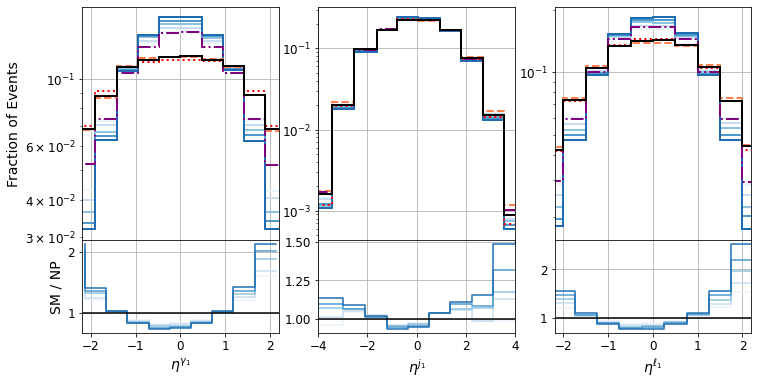

In [29]:
fig,ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
nbins = 10


weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
h_sm = ax[0,0].hist(photon_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    h_np = ax[0,0].hist(photon_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
ax[0,0].hist(photon_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
ax[0,0].hist(photon_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
ax[0,0].hist(photon_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(-2.2,2.2)
ax[1,0].set_xlim(-2.2,2.2)
ax[0,0].set_xticklabels([])
ax[1,0].axhline(y = 1, color = 'black')
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
#ax[0,0].legend(loc='upper right',fontsize=13,bbox_to_anchor=(2.85, 1.35), ncol = 5)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10

weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
h_sm = ax[0,ncol].hist(lepton_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    h_np = ax[0,ncol].hist(lepton_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,ncol].plot([],[], label=name[i], color=cmap(i))
    ax[1,ncol].step( (h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
ax[0,ncol].hist(lepton_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,ncol].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
ax[0,ncol].hist(lepton_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
ax[0,ncol].hist(lepton_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,ncol].grid()
ax[1,ncol].grid()
ax[1,ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[1,ncol].set_ylabel("")
ax[0,ncol].set_yscale('log')
ax[0,ncol].set_xlim(-2.2,2.2)
ax[1,ncol].set_xlim(-2.2,2.2)
ax[0,ncol].set_xticklabels([])
ax[1,ncol].axhline(y = 1, color = 'black')

# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
h_sm = ax[0,ncol].hist(jet_SM[:,1], weights=weights, bins=nbins,
                    lw=2, edgecolor='black', histtype='step', zorder=20)

ax[0,ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    h_np = ax[0,ncol].hist(jet_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,ncol].plot([],[], label=name[i], color=cmap(i))
    ax[1,ncol].step( (h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
ax[0,ncol].hist(jet_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,ncol].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
ax[0,ncol].hist(jet_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
ax[0,ncol].hist(jet_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,ncol].grid()
ax[1,ncol].grid()
ax[1,ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[1,ncol].set_ylabel("")
ax[0,ncol].set_yscale('log')
ax[0,ncol].set_xlim(-4.,4.)
ax[1,ncol].set_xlim(-4.,4.)
ax[0,ncol].set_xticklabels([])
ax[1,ncol].axhline(y = 1, color = 'black')

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_3429386/3178562247.py:15: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_3429386/3178562247.py:93: RuntimeWarning: invalid value encountered in true_divide
  ax[1, ncol].step(h_sm[1][:-1]+0.5, h_sm[0] / h_np[0], color=cmap(i), where = 'mid')


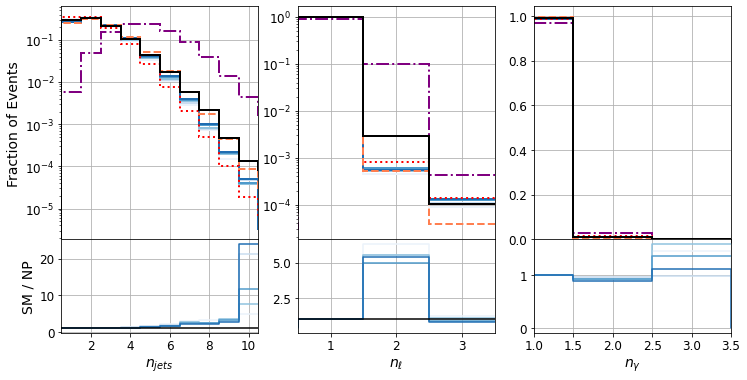

In [40]:
fig,ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))


# Num jets
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

weights = np.ones_like(hadinfo_SM[:,2])/len(hadinfo_SM[:,2])
h_sm = ax[0,0].hist(hadinfo_SM[:,2], weights=weights, bins = nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,2])/len(hadinfo_NP[i][:,2])
    h_np = ax[0,0].hist(hadinfo_NP[i][:,2], weights=weights, bins = nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,2])/len(hadinfo_Wgamma[:,2])
ax[0,0].hist(hadinfo_Wgamma[:,2], weights=weights, bins = nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,2])/len(hadinfo_Wjets[:,2])
ax[0,0].hist(hadinfo_Wjets[:,2], weights=weights, bins = nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,2])/len(hadinfo_ttgamma[:,2])
ax[0,0].hist(hadinfo_ttgamma[:,2], weights=weights, bins = nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0.5,10.5)
ax[1,0].set_xlim(0.5,10.5)
ax[1,0].axhline(y = 1, color = 'black')
ax[0,0].set_xticklabels([])

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)

# Num leptons
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

weights = np.ones_like(lepton_SM[:,3])/len(lepton_SM[:,3])
h_sm = ax[0,1].hist(lepton_SM[:,3], weights=weights, bins = nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,3])/len(lepton_NP[i][:,3])
    h_np = ax[0,1].hist(lepton_NP[i][:,3], weights=weights, bins = nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][1:] + (h_sm[1][1] - h_sm[1][0])*0/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,3])/len(lepton_Wgamma[:,3])
ax[0,1].hist(lepton_Wgamma[:,3], weights=weights, bins = nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,3])/len(lepton_Wjets[:,3])
ax[0,1].hist(lepton_Wjets[:,3], weights=weights, bins = nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,3])/len(lepton_ttgamma[:,3])
ax[0,1].hist(lepton_ttgamma[:,3], weights=weights, bins = nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0.5,3.5)
ax[1,1].set_xlim(0.5,3.5)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])

ax[0,1].set_ylabel("",fontsize=14)
ax[1,1].set_ylabel("", fontsize=14)


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]
weights = np.ones_like(photon_SM[:,3])/len(photon_SM[:,3])
h_sm = ax[0, ncol].hist(photon_SM[:,3], weights=weights, lw=2, edgecolor='black', histtype='step', zorder=20, bins = bins)
ax[0, ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,3])/len(photon_NP[i][:,3])
    h_np = ax[0, ncol].hist(photon_NP[i][:,3], weights=weights, lw=2, edgecolor=cmap(i), histtype='step', zorder=2, bins = bins)
    ax[0, ncol].plot([],[], label=name[i], color=cmap(i))
    #print(h_sm[0] / h_np[0])
    ax[1, ncol].step(h_sm[1][:-1]+0.5, h_sm[0] / h_np[0], color=cmap(i), where = 'mid')

weights = np.ones_like(photon_Wgamma[:,3])/len(photon_Wgamma[:,3])
ax[0, ncol].hist(photon_Wgamma[:,3], weights=weights, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step', bins = bins)
ax[0, ncol].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,3])/len(photon_Wjets[:,3])
ax[0, ncol].hist(photon_Wjets[:,3], weights=weights, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step', bins = bins)
ax[0, ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,3])/len(photon_ttgamma[:,3])
ax[0, ncol].hist(photon_ttgamma[:,3], weights=weights, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step', bins = bins)
ax[0, ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0, ncol].grid()
ax[1, ncol].grid()
ax[1, ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[0, ncol].set_ylabel("")
#ax[1, ncol].set_yscale('log')
ax[0, ncol].set_xlim(1,3.5)
ax[1, ncol].set_xlim(1,3.5)
#ax[1].set_ylim(0.8,1.51)
#ax[1].axhline(y = 1, color = 'black')

ax[0, ncol].set_ylabel("",fontsize=14)
ax[1, ncol].set_ylabel("", fontsize=14)
ax[0, ncol].set_xticklabels([])
#ax[1, ncol].set_yticks([0.8,1,1.2,1.4,1.6])
#ax[1, ncol].ticklabel_format(style='plain')

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

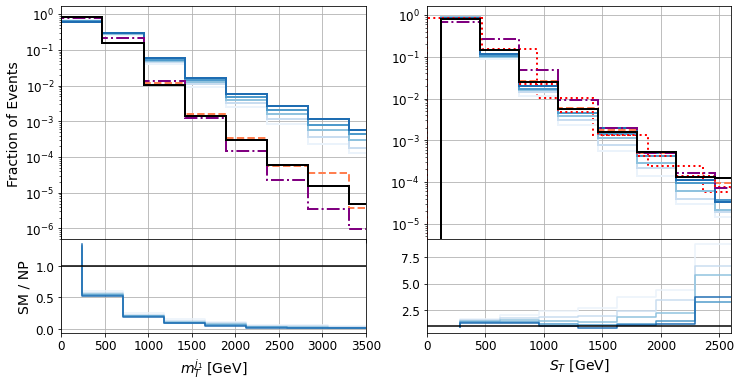

In [41]:
fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4], 'hspace':0}, figsize = (12,6))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = np.asarray([ 0., 472.23, 944.46, 1416.69, 1888.92, 2361.15, 2833.38, 3305.61, 13777.84])

weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
h_sm = ax[0,ncol].hist(mT_jet_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,ncol].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    h_np = ax[0,ncol].hist(mT_jet_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,ncol].plot([],[], label=name[i], color=cmap(i))
    ax[1,ncol].step((h_sm[1][:-1] + (h_sm[1][1] - h_sm[1][0])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
ax[0,1].hist(mT_jet_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
ax[0,ncol].hist(mT_jet_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,ncol].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
ax[0,ncol].hist(mT_jet_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,ncol].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,ncol].grid()
ax[1,ncol].grid()
ax[1,ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[1,ncol].set_ylabel("")
ax[0,ncol].set_yscale('log')
ax[0,ncol].set_xlim(0,3500)
ax[1,ncol].set_xlim(0,3500)
ax[1,ncol].axhline(y = 1, color = 'black')
ax[0,ncol].set_xticklabels([])


# ST info

nbins = np.asarray([121.1, 455.7, 790.4, 1125.0, 1459.6, 1794.3, 2128.9, 2463.625, 3467.56])
weights = np.ones_like(ST_SM)/len(ST_SM)
h_sm = ax[0,1].hist(ST_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(ST_NP[i])/len(ST_NP[i])
    h_np = ax[0,1].hist(ST_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step((h_sm[1][:-1] + (h_sm[1][2] - h_sm[1][1])/2), h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(ST_Wgamma)/len(ST_Wgamma)
ax[0,1].hist(ST_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(ST_Wjets)/len(ST_Wjets)
ax[0,1].hist(ST_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(ST_ttgamma)/len(ST_ttgamma)
ax[0,1].hist(ST_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,2600)
ax[1,1].set_xlim(0,2600)
ax[1,1].axhline(y = 1, color = 'black')
ax[0,1].set_xticklabels([])

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

# Training

In [24]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 9

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(652300, 4)
(652300, 3)
(652300, 5)
(652300, 3)
(652300, 3)
(652300,)
(652300,)
(652300,)
(652300,)
(652300,)
(652300,)


In [25]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

199999

In [26]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,18.81,-0.990,-1.286,1.0,188.58,-1.417,2.954,24.36,0.286,-0.573,...,280.60,237.43,2.0,231.75,9.196400,54.935898,340.853598,21.813775,2.0,0.0
1,14.73,1.635,0.570,1.0,179.51,1.820,-3.059,12.96,1.388,1.317,...,257.73,230.04,2.0,207.20,8.506306,43.122569,302.790298,64.579882,2.0,0.0
2,11.27,1.903,1.128,1.0,123.87,2.227,1.875,23.96,1.870,-2.358,...,313.79,278.56,4.0,159.10,5.830942,52.440558,214.684840,75.822117,2.0,0.0
3,297.98,-0.429,0.140,1.0,144.53,-2.985,2.836,80.18,-0.077,-1.798,...,1127.84,269.52,4.0,522.69,11.748686,484.721289,404.090122,65.085466,1.0,0.0
4,15.26,-1.199,-1.285,1.0,136.22,-0.467,2.630,22.09,-1.613,-1.850,...,173.57,136.22,1.0,173.57,9.143354,27.055127,255.642920,58.551272,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399993,23.14,-0.754,1.754,1.0,348.12,-1.061,2.314,27.92,-1.091,-1.869,...,598.48,547.42,3.0,399.18,19.210794,193.627642,804.858641,133.393983,0.0,1.0
399994,30.58,-1.109,1.351,1.0,279.59,-1.950,0.410,42.41,0.388,-1.877,...,395.03,322.04,2.0,352.58,10.242832,138.394327,476.928887,82.168686,0.0,1.0
399995,20.28,-0.800,0.278,1.0,753.98,-0.359,1.988,21.90,-0.040,-0.084,...,796.16,753.98,1.0,796.16,26.481495,168.178349,1500.191043,138.276360,0.0,1.0
399996,57.60,1.062,1.627,1.0,220.99,-1.672,-0.043,13.29,0.797,-0.572,...,937.77,842.78,6.0,291.88,5.904053,198.043223,332.012000,64.312020,0.0,1.0


In [27]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,27.54,-2.140,-2.675,1.0,273.15,-1.502,1.430,84.08,-1.849,-1.407,...,384.77,273.15,1.0,384.77,8.495809,63.526959,426.701971,34.441960,1.0,0.0
1,33.22,1.531,-0.989,1.0,367.89,0.058,-0.225,42.33,0.409,2.252,...,469.72,394.17,2.0,443.44,13.388994,183.379619,653.378824,68.884724,1.0,0.0
2,25.37,1.751,1.198,1.0,500.45,-1.017,-1.989,241.58,1.751,1.187,...,836.96,570.01,3.0,767.40,6.434093,1.443083,610.085568,6.785499,2.0,0.0
3,17.40,1.271,-0.014,1.0,203.20,1.435,2.157,33.52,-0.722,-1.294,...,305.61,254.69,3.0,254.12,8.512900,58.052284,345.221780,4.660664,1.0,0.0
4,434.01,-1.576,1.475,1.0,378.58,1.109,-1.383,58.49,-0.130,-2.673,...,1058.83,566.33,5.0,871.08,5.175529,490.874972,274.425517,13.982475,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776521,17.20,-0.422,-0.034,1.0,149.81,2.234,-0.386,34.15,-0.379,-2.072,...,249.74,198.39,2.0,201.16,11.006656,98.937369,311.596856,129.086776,0.0,1.0
776522,80.86,-1.390,-0.657,1.0,287.22,-1.783,-3.098,21.00,-1.714,2.236,...,443.46,341.60,3.0,389.08,10.945229,124.749301,510.628319,114.935302,0.0,1.0
776523,41.27,-0.011,1.685,1.0,499.04,0.122,-1.174,64.08,0.615,-1.687,...,1148.86,1043.51,4.0,604.39,10.321631,142.745250,735.487491,218.862349,0.0,1.0
776524,44.35,1.310,-1.844,1.0,331.33,-1.938,0.042,42.97,0.866,1.879,...,418.65,331.33,1.0,418.65,15.436242,138.208292,646.978626,142.225043,0.0,1.0


In [28]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [29]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [30]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [31]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [32]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [33]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))

In [34]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [35]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [36]:
if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 19196 than expected 58462.347349489064
There are less ttgamma events 934 than expected 2877.3979008
There are less Wjets events 19734 than expected 60057.888696312366


In [37]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64983	validation_1-logloss:0.64975
[1]	validation_0-logloss:0.61387	validation_1-logloss:0.61371
[2]	validation_0-logloss:0.58320	validation_1-logloss:0.58307
[3]	validation_0-logloss:0.55768	validation_1-logloss:0.55751
[4]	validation_0-logloss:0.53539	validation_1-logloss:0.53515
[5]	validation_0-logloss:0.51608	validation_1-logloss:0.51582
[6]	validation_0-logloss:0.49906	validation_1-logloss:0.49876
[7]	validation_0-logloss:0.48362	validation_1-logloss:0.48318
[8]	validation_0-logloss:0.47029	validation_1-logloss:0.46982
[9]	validation_0-logloss:0.45833	validation_1-logloss:0.45785
[10]	validation_0-logloss:0.44832	validation_1-logloss:0.44792
[11]	validation_0-logloss:0.43835	validation_1-logloss:0.43796
[12]	validation_0-logloss:0.42983	validation_1-logloss:0.42951
[13]	validation_0-logloss:0.42234	validation_1-logloss:0.42195
[14]	validation_0-logloss:0.41591	validation_1-logloss:0.41560
[15]	validation_0-logloss:0.40954	validation_1-logloss:0.40932
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [38]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [39]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (319998, 22)
y_mon_train :  (319998,)
X_mon_val :  (80000, 22)
y_mon_val :  (80000,)
X_mon_test :  (776526, 22)
y_mon_test :  (776526,)



In [40]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

Text(0.5, 1.0, 'BP10')

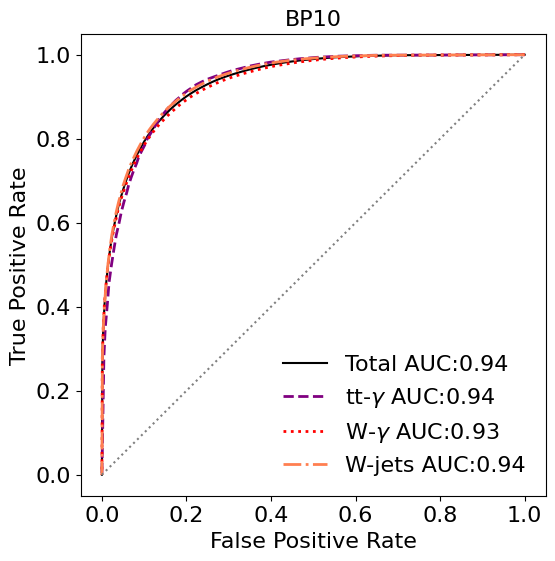

In [41]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)


[Text(0, 0, 'MET sig [GeV]'),
 Text(0, 1, 'lepton $p_T$ [GeV]'),
 Text(0, 2, '$m_T$ lepton [GeV]'),
 Text(0, 3, 'photon $p_T$ [GeV]'),
 Text(0, 4, '$m_T$ photon [GeV]'),
 Text(0, 5, '$S_T$ [GeV]'),
 Text(0, 6, 'num lepton'),
 Text(0, 7, 'photon $\\eta$'),
 Text(0, 8, 'lepton $\\eta$'),
 Text(0, 9, 'MET $p_T$ [GeV]'),
 Text(0, 10, 'jet $\\eta$'),
 Text(0, 11, 'num_jets'),
 Text(0, 12, 'num photon'),
 Text(0, 13, 'lepton $\\phi$'),
 Text(0, 14, 'jet $p_T$ [GeV]'),
 Text(0, 15, '$H_T$ (jets) [GeV]'),
 Text(0, 16, '$H_T$ [GeV]'),
 Text(0, 17, 'photon $\\phi$'),
 Text(0, 18, '$m_T$ jet [GeV]'),
 Text(0, 19, 'num_taus'),
 Text(0, 20, 'MET $\\phi$'),
 Text(0, 21, 'jet $\\phi$')]

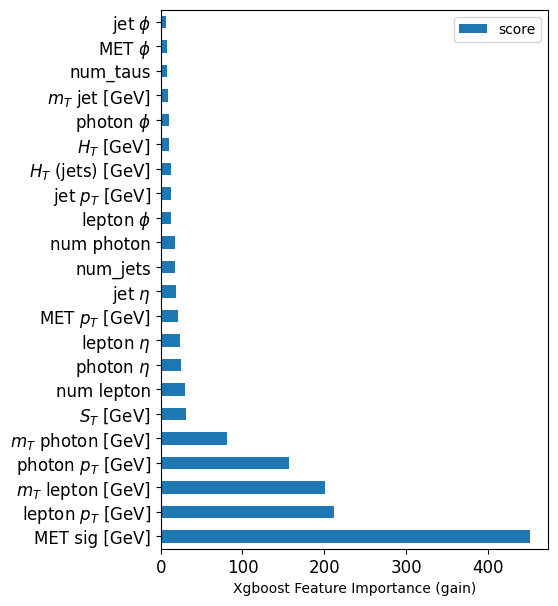

In [42]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])


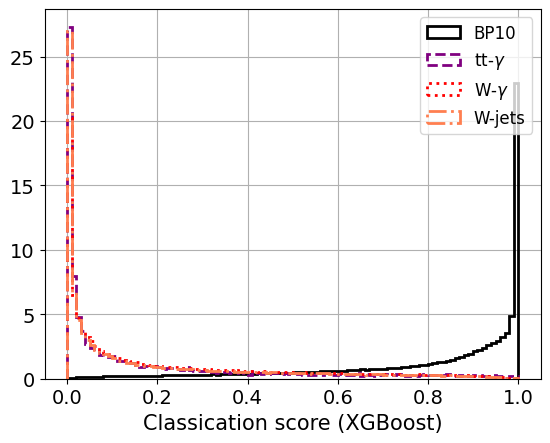

In [43]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)


In [44]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [45]:
with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)

In [46]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]

In [47]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       'photon $p_T$ [GeV]'], dtype='<U18')

In [48]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [49]:
SM = df_test.loc[df_test['bkg_flag_pool'] > 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

In [ ]:
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0, 'wspace':0})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin=0, vmax=1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin=0, vmax=1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars[0])
ax[3,1].set_xlabel(imp_vars[1])
ax[3,2].set_xlabel(imp_vars[2])
ax[3,3].set_xlabel(imp_vars[3])

ax[0,0].set_ylabel(imp_vars[0])
ax[1,0].set_ylabel(imp_vars[1])
ax[2,0].set_ylabel(imp_vars[2])
ax[3,0].set_ylabel(imp_vars[3])

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist.pdf')